In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def weight_init(experts,opening,method=1):
    #add market cap initialization
    if method == 1:
        w = np.ones(experts)
        w[opening.iloc[0]==0] = 0
        w[opening.iloc[0].isnull()] = 0
        return w

def losses(pricerel,returns,time,method=1):
    if method == 1: #price relative #closing over opening
        return -1*returns.iloc[time]
    elif method==2: #absolute return (close-open)
        return -1*pricerel.iloc[time]
    elif method==3: #beta
        return 1

In [50]:
def mwu(data,lossmethod,weightmethod):
    #data = np.array(data)
    #data is a T by N matrix with each row being the returns of each expert i at time t
   
    opening = data.iloc[:,::2]
    closing = data.iloc[:,1::2]
    tickers = opening.columns
    returns = pd.DataFrame()
    for i in range(len(opening.columns)):
        tick = closing.iloc[:,i].name[:4]
        returns[tick]=closing.iloc[:,i]-opening.iloc[:,i]
    
    pricerel = pd.DataFrame()
    for i in range(len(opening.columns)):
        tick = closing.iloc[:,i].name[:4]
        pricerel[tick]=closing.iloc[:,i]/opening.iloc[:,i]
    
    T = len(data)
    N = len(opening.columns)
    epsilon = np.sqrt(np.log(N)/T) 
   
    w = weight_init(N,opening)
    p = w/sum(w)
    
    start = 10000000
    start_open = opening.iloc[0].values
    #return start_open
    start_quant = []
    for j,k in enumerate(start_open):
        #print(p[j]*start)
        if k == 0:
            start_quant.append(0)
        elif p[j] != 0:
            start_quant.append((p[j]*start)/k)
        else:
            start_quant.append(0)
    #print(start_quant*start_open)

    quantities = [start_quant] #$/prices = quantity of each
    #return quantities

    weights = [w]
    values =[]
    transaction = []
    
    for t in range(T):
        #find new prices for the day
        #opening_prices_na = opening.iloc[t]
        opening_prices = opening.iloc[t].values
        opening_prices[opening.iloc[t].isnull()] = 0
        if 0 not in opening_prices:
            w[w==0] = 1
        #closing_prices_na = closing.iloc[t]
        closing_prices = closing.iloc[t].values
        closing_prices[closing.iloc[t].isnull()] = 0
        #return opening_prices
        
        #portfolio value
        values.append(np.sum(np.array(opening_prices)*np.array(quantities[t-1]))) #new opening value
        #return values

        loss = losses(pricerel,returns,t,lossmethod) 
        loss[loss.isnull()] = 0
        M = max(abs(loss))
        loss = losses(pricerel,returns,t,lossmethod)/M
        loss[loss.isnull()] = 0
                
        #check sum of weight updates
        money_moved = sum(np.absolute([-p[i]*epsilon*loss[i] for i in range(N)]))*values[t]
        
        if t==0 or values[t]-values[t-1] >= 0.015*money_moved:
            for i in range(N):
                w[i] = w[i]*(1-epsilon*loss[i])
            transaction.append((t,0.015*money_moved))
        #print(w,transaction)
        
        weights.append(w)
        p = w/sum(w)
        #return p

        q_t = []
        for j,k in enumerate(opening_prices):
            if k == 0:
                q_t.append(0)
            elif p[j] != 0:
                q_t.append((p[j]*values[t])/k)
            else:
                q_t.append(0)
        quantities.append(q_t)
        
#         if t==6:
#             print(loss)
#             print(values)
#             print(quantities)
#             print(opening_prices)
#             print(w,p)
#             return 0
        
    print('Final distribution: ',p)
    print('Final transaction count: ',len(transaction),'total cost: ',sum([v[1] for v in transaction]))
    print('starting value: ',start,'final value: ',values[-1],'less transaction costs: ',values[-1]-sum([v[1] for v in transaction]))
    plt.plot(values)
    plt.show()
    return values

In [70]:
data = pd.read_excel('lowvol_weekly.xlsx')[::-1]
opening = data.iloc[:,::2]

Final distribution:  [0.05190698 0.03613203 0.16834575 0.05312927 0.05433533 0.02843549
 0.04552109 0.05528863 0.06408348 0.03714384 0.00980875 0.05116067
 0.11912706 0.04095012 0.03559247 0.05063796 0.03061373 0.04121175
 0.02657561]
Final transaction count:  355 total cost:  1543161.0021758522
starting value:  10000000 final value:  26366910.227640204 less transaction costs:  24823749.22546435


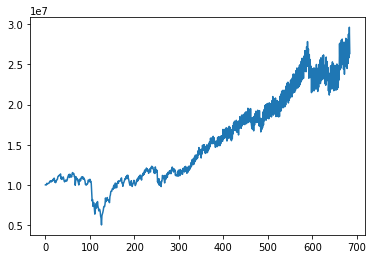

[10000000.0,
 9993819.247373179,
 9983318.066154927,
 10183548.181165434,
 10099628.522805048,
 10159010.035732105,
 10185368.550735302,
 10176326.050198577,
 10204830.309427097,
 10329771.264708266,
 10457926.503104296,
 10390762.248236084,
 10486742.508549152,
 10365917.72794101,
 10527370.279364016,
 10500457.99107649,
 10466821.363111451,
 10679011.408953425,
 10604889.53718098,
 10810226.919605082,
 10825119.562150652,
 10342969.338623539,
 10478335.6487635,
 10271795.009592611,
 10516728.59171715,
 10522723.605991058,
 10658312.7412811,
 10703111.973314442,
 11018459.465540413,
 11073670.70971131,
 11166870.3032776,
 11131261.822802207,
 11212278.312675137,
 11231727.807666639,
 11361710.072044333,
 10752726.450721864,
 10945468.51041197,
 10681731.264532425,
 10783625.677263454,
 10874880.787054304,
 10990163.504952582,
 10809343.60713523,
 10501206.264911039,
 10373919.52219822,
 10485239.766932746,
 10489308.489978656,
 10605675.238022398,
 10466956.150389785,
 10483606.206909

In [71]:
mwu(data,1,1)

Final distribution:  [0.052784   0.05154006 0.0539748  0.05245654 0.05328603 0.05125808
 0.05549376 0.0541003  0.0537197  0.0520804  0.04840681 0.05365219
 0.05445555 0.05297232 0.05263849 0.05333239 0.05172866 0.05289512
 0.0492248 ]
Final transaction count:  344 total cost:  4733003.564997774
starting value:  10000000 final value:  25402864.247795418 less transaction costs:  20669860.682797644


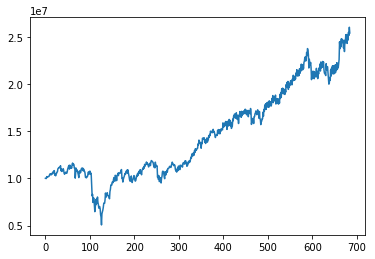

[10000000.0,
 9993819.247373179,
 9983429.326776356,
 10185958.965197654,
 10102771.665388435,
 10162182.16919208,
 10188433.607047068,
 10179191.957544368,
 10207277.75822516,
 10332810.523346435,
 10458176.86534921,
 10391690.972856825,
 10487702.72052179,
 10367648.195916155,
 10529420.43104697,
 10502494.52164869,
 10466388.83743245,
 10679669.83281619,
 10604447.284778686,
 10805194.055287465,
 10819716.60718218,
 10341406.015047511,
 10480403.632824756,
 10270499.239215882,
 10516780.9896956,
 10521239.63812977,
 10656506.343014706,
 10698805.02437687,
 11011487.787828494,
 11062238.321776187,
 11148914.764411042,
 11111494.089755196,
 11188455.454053748,
 11213082.013099838,
 11338199.774506772,
 10800116.39490345,
 10975565.084412877,
 10729223.386804791,
 10819099.791343328,
 10923671.62067696,
 11023896.248011695,
 10859352.781662852,
 10542391.05585108,
 10433086.878015596,
 10536901.420980394,
 10567271.181293735,
 10665630.528914519,
 10535559.783794297,
 10541407.47650471

In [72]:
mwu(data,2,1)

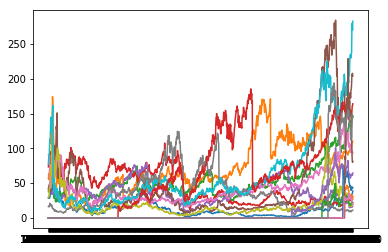

In [58]:
plt.plot(opening)
plt.show()